In [42]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from ydata_profiling import ProfileReport
from pycaret.utils.generic import check_metric

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [43]:
# from pandas_profiling import ProfileReport

In [44]:
data_path = "Churn_prediction\\data\\raw"
raw_file = "Telco-Customer-Churn.xlsx"

In [45]:
os.path.join(data_path, raw_file)

'Churn_prediction\\data\\raw\\Telco-Customer-Churn.xlsx'

In [46]:
data_df = pd.read_excel(os.path.join(data_path, raw_file), sheet_name="WA_Fn-UseC_-Telco-Customer-Chur")

In [47]:
data_df.shape

(7043, 21)

In [48]:
data_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [49]:
data_df.head(2).T

,0,1
customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
SeniorCitizen,0,0
Partner,Yes,No
Dependents,No,No
tenure,1,34
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes


In [50]:
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'].apply(lambda x:str(x).strip()))#.astype(float)
data_df['tenure'] = pd.to_numeric(data_df['tenure'])

In [51]:
data_df['TotalCharges'] = np.where(data_df['TotalCharges'].isna(), data_df['tenure']*data_df['MonthlyCharges'], data_df['TotalCharges'])

In [52]:
data_df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [53]:
report = ProfileReport(data_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
data = data_df.sample(frac=0.8, random_state=42)
data_unseen = data_df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print("Data for Modelling", data.shape)
print("Unseen data for prediction", data_unseen.shape)

Data for Modelling (5634, 21)
Unseen data for prediction (1409, 21)


In [55]:
exp_clf101 = setup(data = data, 
                   target = 'Churn',
                   session_id=123,
                   normalize=True, 
                   transformation=True, 
                   remove_multicollinearity=True, multicollinearity_threshold=0.95,
                  log_experiment=True, experiment_name="Churn_model", ignore_features=['customerID', 'tenure', 'MonthlyCharges'], fix_imbalance=True) 

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(5634, 21)"
5,Transformed data shape,"(7461, 33)"
6,Transformed train set shape,"(5770, 33)"
7,Transformed test set shape,"(1691, 33)"
8,Ignore features,3
9,Ordinal features,5


2024/01/31 16:24:20 INFO mlflow.tracking.fluent: Experiment with name 'Churn_model' does not exist. Creating a new experiment.


In [56]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8042,0.8514,0.8042,0.8054,0.8047,0.5038,0.5041,0.0760
gbc,Gradient Boosting Classifier,0.7999,0.8484,0.7999,0.7952,0.7970,0.4764,0.4775,0.2260
lightgbm,Light Gradient Boosting Machine,0.7956,0.8358,0.7956,0.7877,0.7901,0.4541,0.4566,0.2120
lda,Linear Discriminant Analysis,0.7953,0.8502,0.7953,0.8029,0.7983,0.4949,0.4964,0.0730
ridge,Ridge Classifier,0.7951,0.0000,0.7951,0.8027,0.7981,0.4945,0.4959,0.0740
ada,Ada Boost Classifier,0.7933,0.8497,0.7933,0.8001,0.7961,0.4886,0.4897,0.1280
svm,SVM - Linear Kernel,0.7783,0.0000,0.7783,0.7809,0.7782,0.4377,0.4398,0.0750
rf,Random Forest Classifier,0.7763,0.8160,0.7763,0.7648,0.7679,0.3924,0.3966,0.1480
et,Extra Trees Classifier,0.7603,0.7835,0.7603,0.7501,0.7536,0.3587,0.3611,0.1400
nb,Naive Bayes,0.7324,0.8325,0.7324,0.7994,0.7467,0.4288,0.4579,0.0740


In [57]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8127,0.8490,0.8127,0.8105,0.8115,0.5171,0.5173
1,0.7570,0.7956,0.7570,0.7501,0.7530,0.3620,0.3628
2,0.8557,0.9084,0.8557,0.8553,0.8555,0.6314,0.6314
3,0.7995,0.8475,0.7995,0.7989,0.7992,0.4856,0.4856
4,0.7893,0.8338,0.7893,0.7900,0.7897,0.4628,0.4628
5,0.8325,0.8681,0.8325,0.8298,0.8309,0.5663,0.5668
6,0.7868,0.8183,0.7868,0.7844,0.7855,0.4514,0.4516
7,0.8249,0.8793,0.8249,0.8189,0.8204,0.5339,0.5367
8,0.8198,0.8730,0.8198,0.8173,0.8184,0.5349,0.5352


Fitting 10 folds for each of 10 candidates, totalling 100 fits


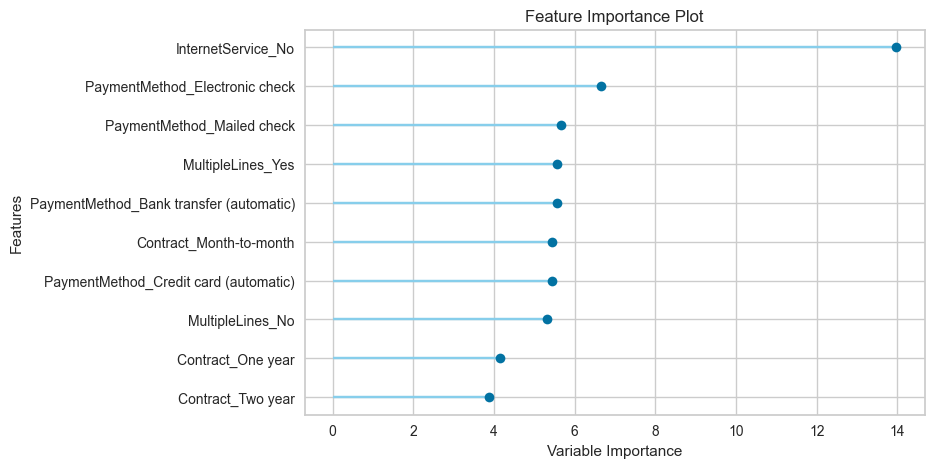

In [58]:
plot_model(tuned_best_model, plot = 'feature')

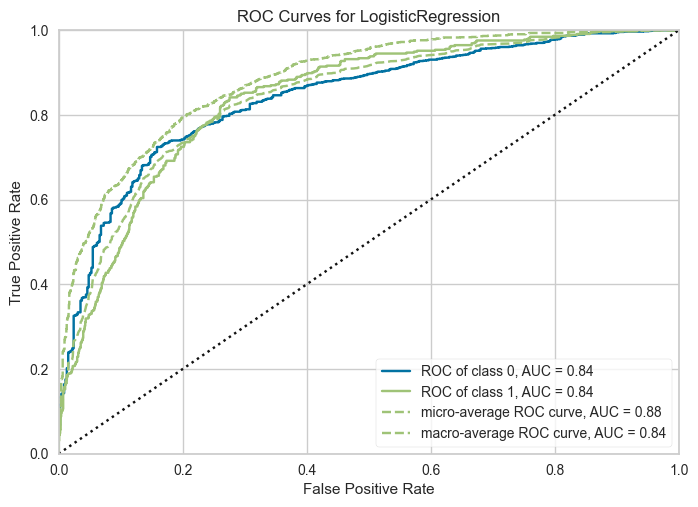

In [59]:
plot_model(tuned_best_model, plot = 'auc')

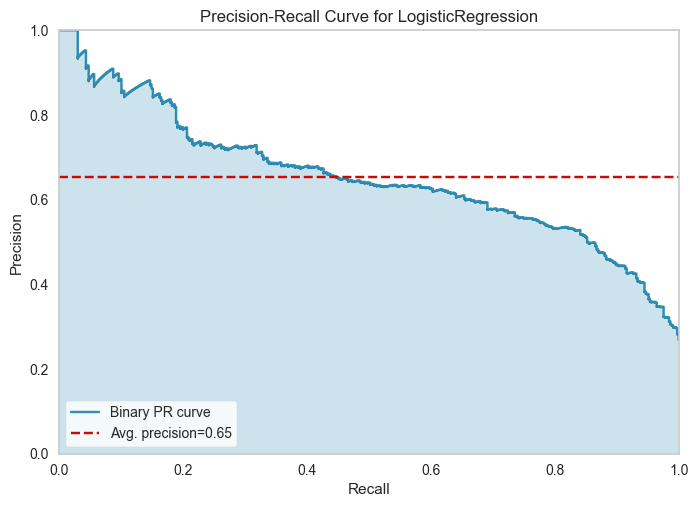

In [60]:
plot_model(tuned_best_model, plot = 'pr')

In [61]:
# gbc_model = create_model('gbc')

In [62]:
# gbc_params = {'n_estimators': np.arange(10, 200, 10),
#               'max_depth': [int(x) for x in np.linspace(10, 100, 10)],
#               'learning_rate': np.arange(0.1, 1.0, 0.1)}

# tuned_gbc = tune_model(gbc_model, custom_grid=gbc_params)

In [63]:
final_best = finalize_model(tuned_best_model)

save_model(final_best, 'Churn_prediction/models/churn-prediction-pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SeniorCitizen', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_va...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=StandardScaler(copy=True,
                                                       

In [64]:
unseen_predictions = predict_model(final_best, data=data_unseen)
unseen_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8048,0.8413,0.8048,0.7977,0.8003,0.4617,0.4635


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
0,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No,No,0.9641
1,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,Yes,0.7964
2,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes,Yes,0.8546
3,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),56.150002,3487.949951,No,No,0.9816
4,8191-XWSZG,Female,0,No,No,52,Yes,No,No,No internet service,...,No internet service,No internet service,One year,No,Mailed check,20.650000,1022.950012,No,No,0.9673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,9710-NJERN,Female,0,No,No,39,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.150000,826.000000,No,No,0.9817
1405,1699-HPSBG,Male,0,No,No,12,Yes,No,DSL,No,...,Yes,No,One year,Yes,Electronic check,59.799999,727.799988,Yes,No,0.7902
1406,0550-DCXLH,Male,0,No,No,13,Yes,No,DSL,No,...,Yes,Yes,Month-to-month,No,Mailed check,73.349998,931.549988,No,No,0.7406
1407,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,44.400002,263.049988,No,Yes,0.7905


In [65]:
# check_metric(unseen_predictions.Churn, unseen_predictions.prediction_label, metric="Recall")